# Introduction


This notebook is focused on charting bio-optics data from the Ocean Observatores Initiative. 
The contents (specifically data charts) should display in **binder**. However the data may be 
stored external to the **ocean** repository; in which case the code that reads datafiles will
not run properly.


> ***Recommendation: The casual reader is encouraged to skim down to charts and captions.***


<BR>
<img src="./Images/rca/shallow%20profiler%20platform%201%20in%20situ.png" style="float: left;" alt="drawing" width="400"/>
<div style="clear: left"><BR>


In [41]:
import os, sys, time, glob, warnings
from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
warnings.filterwarnings('ignore')
this_dir = os.getcwd()
data_dir = this_dir + '/../data'                  # large datasets reside outside the repository

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

# convenience functions abbreviating 'datetime64' and so on
def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [42]:
# Shallow profiler metadata (timestamps for Ascent / Descent / Rest are stored in a set of files in
#   the Profiles subdirectory. These are read into a Pandas Dataframe in the function given below.
#
# Specific to the profile files: We have CSV files with columns corresponding to ascent start, etcetera.
# This function reads and assorts these time stamps. It keeps them in chronological order but there is
#   at the moment no further metadata; for example concerning time of day.

def ReadProfileMetadata(fnm):
    """
    Profiles are saved by site and year as 12-tuples. Here we read only
    the datetimes (not the indices) so there are only six values. These
    are converted to Timestamps. They correspond to ascend start/end, 
    descend start/end and rest start/end. Timestamps are a bit easier to
    use than datetime64 values, being essentially wrappers around the latter with
    additional utility.
    """
    df = pd.read_csv(fnm, usecols=["1", "3", "5", "7", "9", "11"])
    df.columns=['ascent_start', 'ascent_end', 'descent_start', 'descent_end', 'rest_start', 'rest_end']
    df['ascent_start']  = pd.to_datetime(df['ascent_start'])
    df['ascent_end']    = pd.to_datetime(df['ascent_end'])
    df['descent_start'] = pd.to_datetime(df['descent_start'])
    df['descent_end']   = pd.to_datetime(df['descent_end'])
    df['rest_start']    = pd.to_datetime(df['rest_start'])
    df['rest_end']      = pd.to_datetime(df['rest_end'])
    return df


def GenerateTimeWindowIndices(df, date0, date1, time0, time1):
    '''
    Given two day boundaries and a time window (UTC) within a day: Return a list
    of indices of profiles that start within both the day and time bounds. This 
    works from the passed dataframe of profile times.
    '''
    nprofiles = len(df)
    pIndices = []
    for i in range(nprofiles):
        a0 = df["ascent_start"][i]
        if a0 >= date0 and a0 <= date1:
            delta_t = a0 - dt64(a0.date())
            if delta_t >= time0 and delta_t <= time1: pIndices.append(i)
    return pIndices

In [43]:
# global parameters: for osb shallow profiler data

# axis ranges for a variety of sensors
par_lo,         par_hi           =   -10.0,      300.
nitrate_lo,     nitrate_hi       =     0.,        50.
do_lo,          do_hi            =    50.0,      300.
chlora_lo,      chlora_hi        =    -0.1,        1.2
temp_lo,        temp_hi          =     6.5,       11.
salinity_lo,    salinity_hi      =    32.0,       35.
backscatter_lo, backscatter_hi   =     0.0007,     0.0020
cdom_lo,        cdom_hi          =     0.6,        1.4
si412_lo,       si412_hi         =     0.0,       80.0
si443_lo,       si443_hi         =     0.0,       80.0
si490_lo,       si490_hi         =     0.0,       80.0
si510_lo,       si510_hi         =     0.0,       80.0
si555_lo,       si555_hi         =     0.0,       80.0
si620_lo,       si620_hi         =     0.0,       15.0
si683_lo,       si683_hi         =     0.0,        6.0
veast_lo,       veast_hi         =    -0.4,        0.4
vnorth_lo,      vnorth_hi        =    -0.4,        0.4
vup_lo,         vup_hi           =    -0.4,        0.4

# ax.plot(dsI.time, dsI.si683,

# time ranges for midnight and noon profiles, adjusted for UTC
midn0 = td64( 7*60 + 10, 'm')        # 7 hours 10 minutes
midn1 = td64( 7*60 + 34, 'm')        # 7 hours 34 minutes
noon0 = td64(20*60 + 30, 'm')        # 20 hours 30 minutes
noon1 = td64(20*60 + 54, 'm')        # 20 hours 54 minutes 

In [44]:
# Concerning the names of data variables
# Some engineering elements of OOI result in complex names. This commented-out code fragment demonstrates
#   opening a NetCDF file as an XArray Dataset and renaming a data variable to something simpler.
#
# dsO = xr.open_dataset(data_dir + "/data_explorer_1Min/axb/profiler/axb_profiler_doxygen_1Min.nc")
# dsO = dsO.rename_vars({"moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled":"doxygen"})
# dsO

In [45]:
# This cell loads up selected datasets from the data pool.
#
# To keep code compact I use the following table of abbreviations for sensors.
#   BioOptics includes Fluorometers, the main emphasis here. Fluorometers carry either two or
#   three sensor types: Chlorophyll-A, Color Dissolved Organic Matter (CDOM), and particulate backscatter. 
#   The BioOptics ensemble also includes PAR and Spectral Irradiance. PAR measurements are individual
#   values. Spectral irradiance is seven values per observation. Spectrophotometers are not considered
#   in this notebook.
#
# Dictionary of single-letter sensor keys: The capitalized letter follows 'ds', an abbreviation for
#   an XArray Dataset. We have therefore: dsA, dsB, dsC, etcetera
#
# Desig     Data                     Renamed                 Instrument
# -----     ----                     -------                 ----------
# A         Chlorophyll-A            chlora                  fluorometer
# B         backscatter              backscatter             fluorometer
# C         CDOM                     cdom                    fluorometer
# G         pCO2                     pco2                    ?
# H         pH                       ph                      pH
# I         Spectral Irradiance      ?                       spkir
# M         Reserved for Nitrate'    ?                       nitrate
# N         Nitrate                  ?                       nitrate
# P         PAR                      par                     PAR
# Q         pressure                 pressure                CTD
# O         dissolved oxygen         doxygen                 CTD
# S         salinity                 salinity                CTD
# T         temperature              temp                    CTD
# U         velocity east            veast                   ADCP
# V         velocity north           vnorth                  ADCP
# W         velocity up              vup                     ADCP
#
# 
# Shallow profilers begin at rest at a depth of 200 meters. They ascend to within
#   about 10 meters of the surface, then descend to create a double profile dataset;
#   whereupon they return to the at-rest state. This cycle repeats nine times per
#   day. What follows is a simple dictionary of interval designators: The capital letter 
#   follows the sensor key
#
# A     Ascent
# D     Descent
# R     Rest
#
#
# There are three RCA shallow profiler sites with names abbreviated herein:
#
# osb           Oregon Slope Base
# axb           Axial Base
# oos           Oregon Offshore (part of the Endurance array)
#
# For more on this see the README.md file and the Notebooks subdirectory.

# Note these are profile times for Axial Base
df = ReadProfileMetadata(os.getcwd()+"/./Profiles/osb2021.csv")

# These data files for Oregon Slope Base were pulled from the OOI "data explorer" and stored 
#   in the data directory outside this repository. The data are timestamped at one minute intervals.

data_source = data_dir + '/data_explorer_1Min/'

dsA = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_chlora_1Min.nc')
dsB = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_backscatter_1Min.nc')
dsC = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_cdom_1Min.nc')
dsO = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_doxygen_1Min.nc')
dsS = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_salinity_1Min.nc')
dsT = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_temperature_1Min.nc')

dsA = dsA.rename_vars({"mass_concentration_of_chlorophyll_a_in_sea_water_profiler_depth_enabled":"chlora"})
dsB = dsB.rename_vars({"flubsct_profiler_depth_enabled":"backscatter"})
dsC = dsC.rename_vars({"cdomflo_profiler_depth_enabled":"cdom"})
dsO = dsO.rename_vars({"moles_of_oxygen_per_unit_mass_in_sea_water_profiler_depth_enabled":"doxygen"})
dsS = dsS.rename_vars({"sea_water_practical_salinity_profiler_depth_enabled":"salinity"})
dsT = dsT.rename_vars({"sea_water_temperature_profiler_depth_enabled":"temp"})

## Profile duration

This section demonstrates how two of nine daily profiles are extended in duration.

`dt64_from_doy(2021, 60)` converts Day Of Year to datetime64 `numpy.datetime64('2021-03-01')`.

Via trial and error March 1 proves to be 2021 profile number 503 at Oregon Slope Base. The time of
day is UTC, 8 hours ahead of local. Consequently this code


```
for i in [503, 504, 505, 506]:
    print(i, 'profile start / end:', df["ascent_start"][i], df["descent_end"][i], \
          '      duration: ', df["descent_end"][i] - df["ascent_start"][i]) 
```

produces these results: 


```
503 profile start / end: 2021-03-01 00:27:00 2021-03-01 02:05:00       duration:  0 days 01:38:00
504 profile start / end: 2021-03-01 02:42:00 2021-03-01 04:21:00       duration:  0 days 01:39:00
505 profile start / end: 2021-03-01 04:52:00 2021-03-01 06:31:00       duration:  0 days 01:39:00
506 profile start / end: 2021-03-01 07:22:00 2021-03-01 10:03:00       duration:  0 days 02:41:00
```

Profile 506 is an hour longer in duration than the others owing to interval pauses on descent.
This is the midnight-local profile. Profile 578 is midnight-local on March 9. Hence profiles 506
through 577 represent eight days of data, 72 profiles.

The following chart shows depth with time over 24 hours, including the longer descents at midnight and noon.


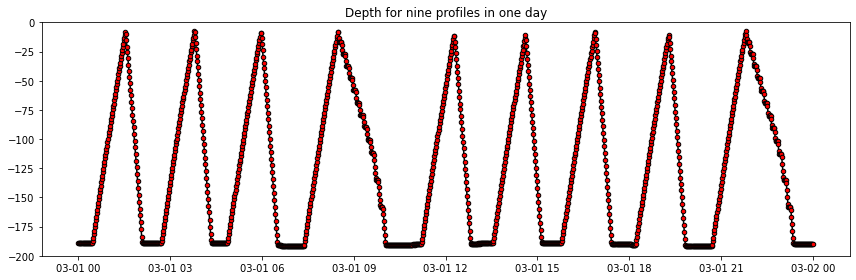

In [46]:
dsT_1d = dsT.sel(time=slice(dt64('2021-03-01'), dt64('2021-03-02')))
fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
axs.plot(dsT_1d.time, dsT_1d.z, marker='.', ms=9., color='k', mfc='r')
axs.set(ylim = (-200., 0.), title='Depth for nine profiles in one day'); print()

In [47]:
def ChartAB(df, xrng, pIdcs, A, Az, Albl, Acolor, B, Bz, Blbl, Bcolor):
    """
    Make a series of charts comparing two types of sensor data, A and B.
    The data are passed in as DataArrays: A and Az are data and z coordinates respectively.
    So A might be dsP.par (PAR DataArray) and depth Az would be dsP.z. Both use time as 
    their dimension. Charting is done over a set of passed profile indices pIdcs[].
    The number of profiles charted is constrained: Too many may bog down the kernel.
    """
    global midn0, midn1, noon0, noon1
        
    # if too many charts are requested: Take the first 117 only
    ncharts = len(pIdcs)
    if ncharts > 117: ncharts = 117
    print("Attempting", ncharts, "charts\n")

    # set up the requested number of charts in a vertical column
    fig, axs = plt.subplots(ncharts, 1, figsize=(12, 4*ncharts), tight_layout=True)

    # create a list of twin axes, one for each chart
    axstwin0 = [axs[i].twiny() for i in range(ncharts)]

    # this index i will range across the dataframe indices for ascent profiles
    for i in range(ncharts):
        
        # Need both a profile index into the profile dataframe df and a chart
        #   index 0, 1, 2, ... These are respectively pIdx and i
        pIdx = pIdcs[i]

        ta0, ta1 = df["ascent_start"][pIdx], df["ascent_end"][pIdx]

        Ax, Ay = A.sel(time=slice(ta0,  ta1)), Az.sel(time=slice(ta0, ta1))
        Bx, By = B.sel(time=slice(ta0,  ta1)), Bz.sel(time=slice(ta0, ta1))
        
        axs[i].plot(Ax, Ay, ms = 4., color=Acolor, mfc=Acolor)
        axstwin0[i].plot(Bx, By, markersize = 4., color=Bcolor, mfc=Bcolor)
        
        # axis ranges
        if i == 0: axs[i].set(title = Albl + ' (' + Acolor + ', lower x-axis) and ' \
                                    + Blbl + ' (' + Bcolor + ', upper x-axis)')

        # Set axis ranges from passed list of pairs xrng[][]
        axs[i].set(     xlim = (xrng[0][0], xrng[0][1]), ylim = (-200., 0.))
        axstwin0[i].set(xlim = (xrng[1][0], xrng[1][1]), ylim = (-200., 0.))

        # chart timestamp (embellish for noon / midnight)
        ascent_start_time = 'Start UTC: ' + str(ta0)
        delta_t = ta0-dt64(ta0.date())
        if delta_t > midn0 and delta_t < midn1: ascent_start_time += " MIDNIGHT local"
        if delta_t > noon0 and delta_t < noon1: ascent_start_time += " NOON local"

        xlabel = xrng[0][0] + (xrng[0][1] - xrng[0][0])/2.
        axs[i].text(xlabel, -10., ascent_start_time)
        
    return fig, axs

Attempting 20 charts



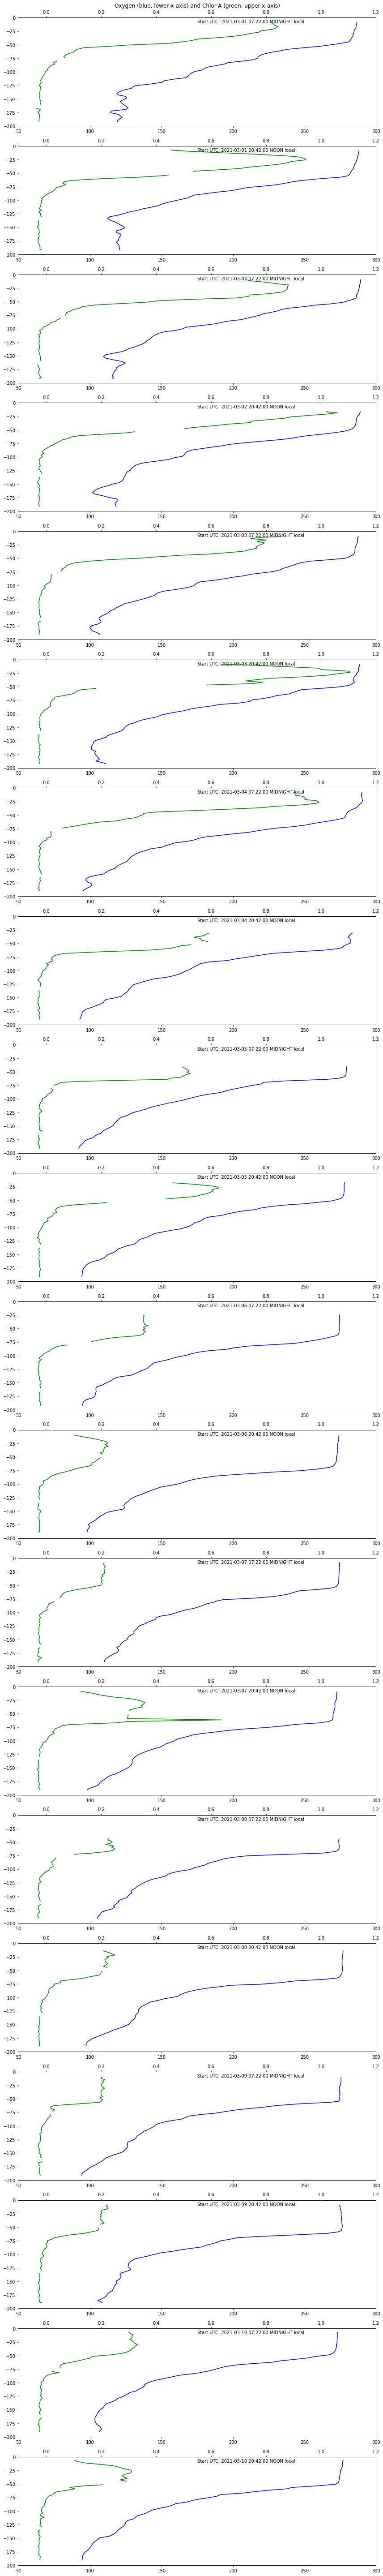

In [48]:
xrng=[(do_lo, do_hi), (chlora_lo, chlora_hi)]                      # dissolved oxygen and chlorophyll-a

# various methods of generating the profile index list
# pIdcs = GenerateTimeWindowIndices(df, dt64_from_doy(2021, 60), dt64_from_doy(2021, 65), noon0, noon1)
# pIdcs = [506, 507, 508, 509, 510, 511, 512, 513, 514]
# pIdcs = [i for i in range(1200,1210)]

# These alternate midnight/noon for ten days starting March 1 2021:
pIdcs = [506, 511, 515, 520, 524, 529, 533, 538, 542, 547, 551, 556, 560, 565, 569, 574, 578, 583, 587, 592] 
fig, axs = ChartAB(df, xrng, pIdcs, dsO.doxygen, dsO.z, 'Oxygen', 'blue', dsA.chlora, dsA.z, 'Chlor-A', 'green')

## Comparison of chlorophyll to oxygen

This comparison sequence shows data from shallow profiler ascents. Instruments 
are upward-facing into relatively undisturbed water as the profiler rises. 


The charts above, on casual inspection, show

- Oxygen profiles are fairly consistent and stable over ten days
- Chlorophyll has larger relative variation but trends appear consistent, not noisy
- Chlorophyll features more data dropouts, typically somewhere in the 45 to 85 meter depth range
- Chlorophyll is either flat with depth at the top of the profile or shows a distinct drop-off
- The transition from mixed layer to pycnocline is consistent between oxygen and chlorophyll 

In [49]:
fig.savefig(os.getcwd() + "/Images/charts/Oxygen_Chlorophyll_signals_vs_depth_and_time.png")
print("figure saved to Images/charts")

figure saved to Images/charts


In [50]:
def SixSignalChartSequence(df, xrng, chart_indices = [506]):
    """
    This chart sequence shows chlorophyll, cdom, backscatter, temperature, dissolved oxygen and salinity with depth.
    These six sensor types are broken into three 'double-sensor' charts in a row.
    Only ascent data are shown; for a set of passed profile indices.
    That is: This function out-sources profile index generation to the calling code.
    The default produces a single chart sequence (profile 506) taken midnight-local March 1 2021.
    The number of profiles is constrained as too many may bog down the kernel.
    """
    
    global dsA, dsB, dsC, dsO, dsS, dsT   # respective: chlor-A, backscatter, CDOM, oxygen, salinity, temperature
    global midn0, midn1, noon0, noon1     # timedelta ranges
    
    ncharts = len(chart_indices)
    if ncharts > 117: ncharts = 117
    print("Attempting", ncharts, "chart sequences")

    fig, axs = plt.subplots(ncharts, 3, figsize=(15, 4*ncharts), tight_layout=True)

    axstwin0 = [axs[i][0].twiny() for i in range(ncharts)]
    axstwin1 = [axs[i][1].twiny() for i in range(ncharts)]
    axstwin2 = [axs[i][2].twiny() for i in range(ncharts)]

    for i in range(ncharts):

        # chart row index is i; profile index (dataframe df) is pIdx
        pIdx = chart_indices[i]

        ta0, ta1 = df["ascent_start"][pIdx], df["ascent_end"][pIdx]

        A = dsA.sel(time=slice(ta0,  ta1))
        B = dsB.sel(time=slice(ta0,  ta1))
        C = dsC.sel(time=slice(ta0,  ta1))
        O = dsO.sel(time=slice(ta0,  ta1))
        S = dsS.sel(time=slice(ta0,  ta1))
        T = dsT.sel(time=slice(ta0,  ta1))

        axs[i][0].plot(  T.temp,     T.z, ms = 4., color='black',             mfc='black')
        axstwin0[i].plot(S.salinity, S.z, ms = 4., color='xkcd:blood orange', mfc='xkcd:blood orange')

        axs[i][1].plot(  O.doxygen, O.z, ms = 4., color='xkcd:blue',  mfc='xkcd:blue')
        axstwin1[i].plot(A.chlora,  A.z, ms = 4., color='xkcd:green', mfc='xkcd:green')

        axs[i][2].plot(  B.backscatter, C.z, ms = 4., color='xkcd:pale violet',  mfc='xkcd:pale violet')
        axstwin2[i].plot(C.cdom,        C.z, ms = 4., color='red',               mfc='red')
        
        # axis ranges
        if i == 0: 
            axs[i][0].set(title='Temperature (black) and Salinity (orange)')
            axs[i][1].set(title='DO (blue) and Chlorophyll (green)')
            axs[i][2].set(title='CDOM (red) and Backscatter (violet)')

        # Set axis ranges from passed list of pairs xrng[][]
        # Order is temp, salinity (left), DO, Chlor-A (center), backscatter, CDOM (right) 
        axs[i][0].set(xlim   = (xrng[0][0], xrng[0][1]), ylim = (-200., 0.))
        axstwin0[i].set(xlim = (xrng[1][0], xrng[1][1]), ylim = (-200., 0.))
        axs[i][1].set(xlim   = (xrng[2][0], xrng[2][1]), ylim = (-200., 0.))
        axstwin1[i].set(xlim = (xrng[3][0], xrng[3][1]), ylim = (-200., 0.))
        axs[i][2].set(xlim   = (xrng[4][0], xrng[4][1]), ylim = (-200., 0.))
        axstwin2[i].set(xlim = (xrng[5][0], xrng[5][1]), ylim = (-200., 0.))

        # labels
        ascent_start_time = str(ta0)
        delta_t = ta0-dt64(ta0.date())
        if delta_t > midn0 and delta_t < midn1: ascent_start_time += "\n MIDNIGHT local"
        if delta_t > noon0 and delta_t < noon1: ascent_start_time += "\n NOON local"

        axstwin0[i].text(xrng[1][0] + 0.7, -20., ascent_start_time)
        
        axs[i][0].text(     xrng[0][1] - 0.6, -75, 'Temp', color='black')
        axstwin0[i].text(xrng[1][0] + 0.1, -75, 'Sal', color='xkcd:blood orange')

        axs[i][1].text(xrng[2][1]-22, -25, 'DO', color='blue')
        axstwin1[i].text(xrng[3][0]+0.05, -25, 'Chl-A', color='green')

        axs[i][2].text(xrng[4][1]-0.00015, -50, 'SCATT', color='xkcd:pale violet')
        axstwin2[i].text(xrng[5][0]+0.02, -50, 'CDOM', color='red')
        
    return fig, axs  

Attempting 20 chart sequences


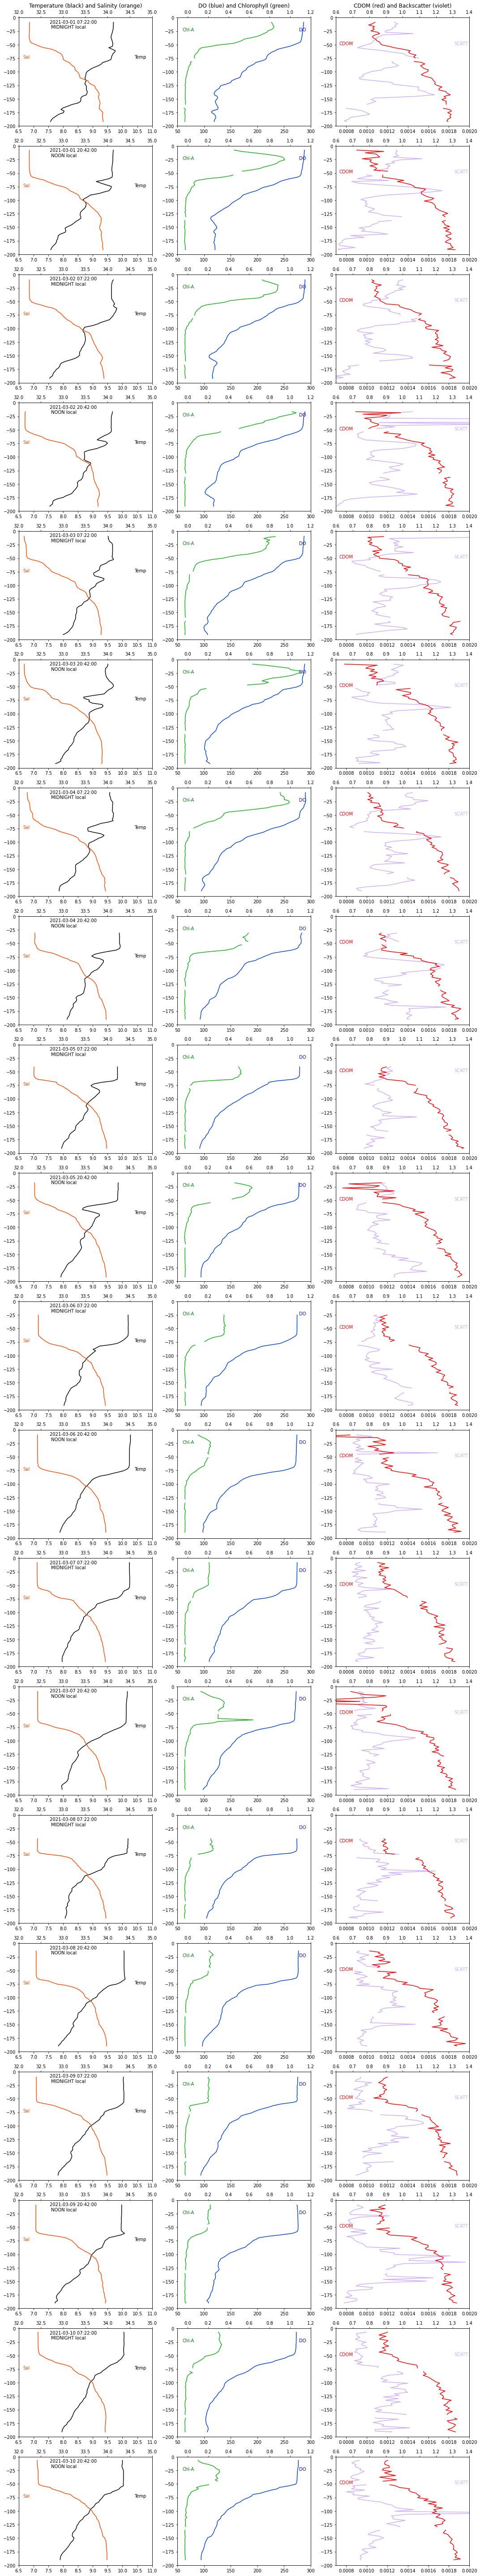

In [51]:
xrng=[(temp_lo, temp_hi), (salinity_lo, salinity_hi), (do_lo, do_hi), \
      (chlora_lo, chlora_hi), (backscatter_lo, backscatter_hi), (cdom_lo, cdom_hi)]

profile_indices = [506, 511, 515, 520, 524, 529, 533, 538, 542, 547, 551, 556, 560, 565, 569, 574, 578, 583, 587, 592] 

fig, axs = SixSignalChartSequence(df, xrng, profile_indices)

## Comparison of chlor-a cdom backscatter salinity temperature oxygen

This comparison sequence expands on the one above by including CDOM, backscatter, temperature
and salinity in addition to Chlorophyll-A and dissolved oxygen. As before these charts show 
data from shallow profiler ascents.

These charts show

- Backscatter data are highly variable with depth; are they reliable? 

In [52]:
fig.savefig(os.getcwd() + "/Images/charts/ABCOST_signals_vs_depth_and_time.png")
print("figure saved to Images/charts")

figure saved to Images/charts


In [53]:
def ProfileEvaluation(t0, t1, df):
    '''
    At this time the profile metadata in df is broken up by year of interest and site.
    For example the code above concerns Oregon Slope Base (osb) and the year 2021. 
    Only profiles through June are available.
    
    This function evaluates profiles within a given time range: How many profiles are there?
    How many 'local noon', how many 'local midnight'? This is a simple way to check profiler 
    operating consistency. This depends in turn on the profiler metadata reliability.
    '''
    global midn0, midn1, noon0, noon1
    
    nTotal = 0
    nMidn = 0
    nNoon = 0
    nNinePerDay = 0

    for i in range(len(df)):
            
        if df["ascent_start"][i] >= t0 and df["ascent_start"][i] <= t1:
            nTotal += 1
            
            if df["descent_end"][i] - df["descent_start"][i] >= td64(60, 'm'):
                
                tProf = df["ascent_start"][i]
                day_time = tProf - dt64(tProf.date())

                if   day_time > midn0 and day_time < midn1: nMidn += 1
                elif day_time > noon0 and day_time < noon1: nNoon += 1
                else: print("found a long descent that did not fit noon or midnight...")
        
    return nTotal, nMidn, nNoon

t0, t1 = dt64('2021-01-01'), dt64('2021-02-01')
nDays = (t1 - t0).astype(int)
nTotal, nMidn, nNoon = ProfileEvaluation(t0, t1, df)

print("For 2021, month of January, we have...")
print(nDays, 'days or', nDays*9, 'possible profiles')
print("There were, over this time, in fact...")
print(nTotal, 'profiles;', nMidn, 'at local midnight and', nNoon, 'at local noon')

For 2021, month of January, we have...
31 days or 279 possible profiles
There were, over this time, in fact...
256 profiles; 28 at local midnight and 29 at local noon


## Additional datasets

To this point we have looked at three CTD-based sensor types and three fluorometer types. 
We now consider: 

```
G        pCO2              <Note: No pCO2 data available for RCA Oregon Slope Base in 2021>
H        pH
N        nitrate
I        spectral irradiance (7 channels within the Dataset)
P        PAR
U        Velocity Eastward
V        Velocity Northward
W        Velocity Upward
```


In [54]:
data_source = data_dir + '/data_explorer_1Min/' 

# To recap the relevant part of the single-letter-code table...
#
# Desig     Data                     Renamed                     Instrument
# -----     ----                     -------                     -----------
# G         pCO2                     pco2                        ?
# H         pH                       ph                          pH
# I         Spectral Irradiance      si412, si443, si490,        spkir
#                                    si510, si555, si620, si683   
# N         Nitrate                  nitrate                     nitrate
# P         PAR                      par                         PAR
# Q         pressure                 pressure                    CTD
# O         dissolved oxygen         doxygen                     CTD
# S         salinity                 salinity                    CTD
# T         temperature              temp                        CTD
# U         velocity east            veast                       ADCP?
# V         velocity north           vnorth                      ADCP?
# W         velocity up              vup                         ADCP?

# pCO2: no data
# dsG = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_pco2_1Min.nc')
# dsG = dsG.rename_vars({"partial_pressure_of_carbon_dioxide_in_sea_water_profiler_depth_enabled":"pco2"})

dsH = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_ph_1Min.nc')
dsI = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_spkir_1Min.nc')
dsN = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_nitrate_1Min.nc')
dsP = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_par_1Min.nc')
dsU = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_veleast_1Min.nc')
dsV = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_velnorth_1Min.nc')
dsW = xr.open_dataset(data_source + 'osb/profiler/osb_profiler_velup_1Min.nc')


dsH = dsH.rename_vars({"sea_water_ph_reported_on_total_scale_profiler_depth_enabled":"ph"})
dsI = dsI.rename_vars({"spectir_412nm":"si412",  \
                       "spectir_443nm":"si443", \
                       "spectir_490nm":"si490", \
                       "spectir_510nm":"si510", \
                       "spectir_555nm":"si555", \
                       "spectir_620nm":"si620", \
                       "spectir_683nm":"si683"})
dsN = dsN.rename_vars({"mole_concentration_of_nitrate_in_sea_water_profiler_depth_enabled":"nitrate"})
dsP = dsP.rename_vars({"downwelling_photosynthetic_photon_flux_in_sea_water_profiler_depth_enabled":"par"})
dsU = dsU.rename_vars({"eastward_sea_water_velocity_profiler_depth_enabled":"veast"})
dsV = dsV.rename_vars({"northward_sea_water_velocity_profiler_depth_enabled":"vnorth"})
dsW = dsW.rename_vars({"upward_sea_water_velocity_profiler_depth_enabled":"vup"})

Attempting 30 charts



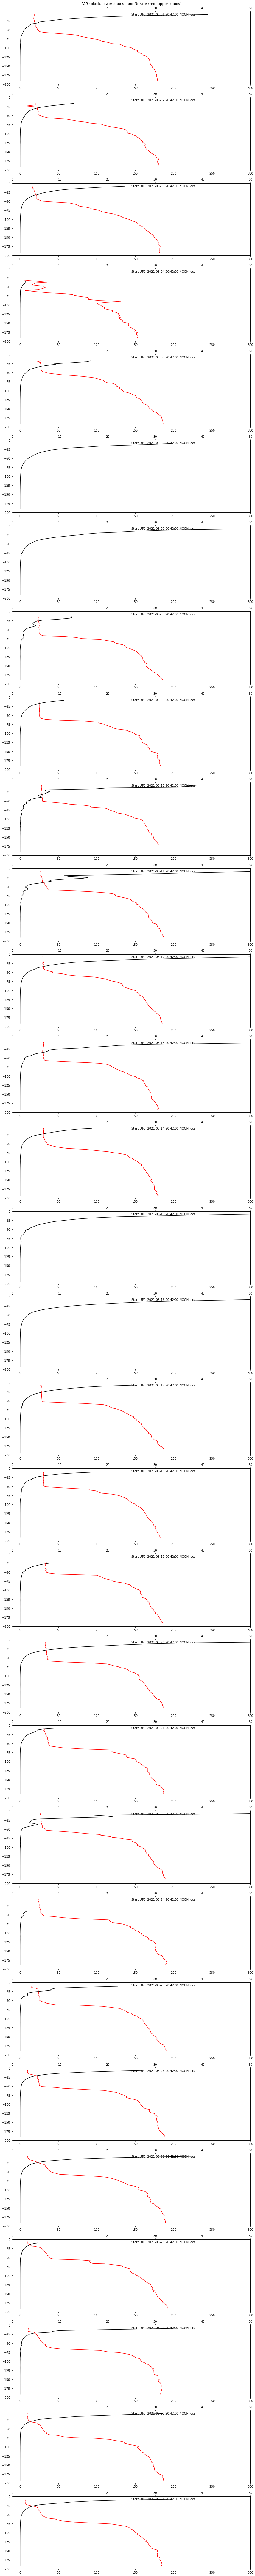

In [55]:
xrng = [(par_lo, par_hi), (nitrate_lo, nitrate_hi)]

# profile_indices = [506, 507, 508, 509, 510, 511, 512, 513, 514]
# profile_indices = [i for i in range(1200,1210)]

pIdcs = GenerateTimeWindowIndices(df, dt64_from_doy(2021, 60), dt64_from_doy(2021, 91), noon0, noon1)
fig, axs = ChartAB(df, xrng, pIdcs, dsP.par, dsP.z, 'PAR', 'black', dsN.nitrate, dsN.z, 'Nitrate', 'red')

In [56]:
# This cell can be used to glance at data availability for each type of data. It uses a 
#   very simple plot call to show presence/absence over the history of the cabled array
#   deployment. Both pCO2 and pH are 'no data' results; and upward velocity looks suspicious.
#   The other datasets look to be present during the first half of 2021.
#
# To recap the relevant part of the single-letter-designator table...
#
# Desig     Data                     Renamed                     Instrument
# -----     ----                     -------                     -----------
# G         pCO2                     pco2                        ?
# H         pH                       ph                          pH
# I         Spectral Irradiance      si412, si443, si490,        spkir
#                                    si510, si555, si620, si683   
# N         Nitrate                  nitrate                     nitrate
# P         PAR                      par                         PAR
# U         velocity east            veast                       ADCP?
# V         velocity north           vnorth                      ADCP?
# W         velocity up              vup                         ADCP?

# un-comment the next line and one of the sensor lines that follow
# fig, ax = plt.subplots(figsize=(12, 8), tight_layout=True)

# ax.plot(dsG.time, dsG.pco2,     ms = 1., color='blue', mfc='blue')    # no data
# ax.plot(dsH.time, dsH.ph,       ms = 1., color='blue', mfc='blue')    # no data
# ax.plot(dsI.time, dsI.si412,    ms = 1., color='blue', mfc='blue')    # good first half of 2021 (max 80)
# ax.plot(dsI.time, dsI.si443,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si490,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si510,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si555,    ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsI.time, dsI.si620,    ms = 1., color='blue', mfc='blue')    # "  (max down around 15)
# ax.plot(dsI.time, dsI.si683,    ms = 1., color='blue', mfc='blue')    # "  (max down around 6)
# ax.plot(dsN.time, dsN.nitrate,  ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsO.time, dsO.doxygen,  ms = 1., color='blue', mfc='blue')    # " 
# ax.plot(dsP.time, dsP.par,      ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsS.time, dsS.salinity, ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsT.time, dsT.temp,     ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsU.time, dsU.veast,    ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsV.time, dsV.vnorth,   ms = 1., color='blue', mfc='blue')    # "
# ax.plot(dsW.time, dsW.vup,      ms = 1., color='blue', mfc='blue')    # " suspiciously high amplitude in 2021


Attempting 30 charts



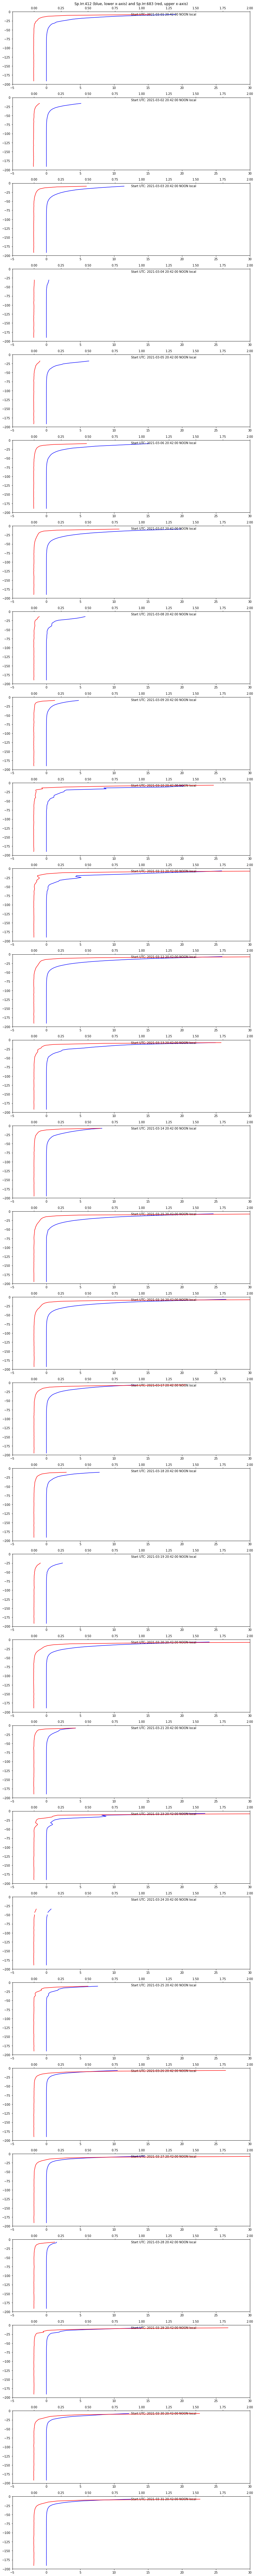

In [57]:
xrng = [(-5., 30.), (-.2, 2.)]
pIdcs = GenerateTimeWindowIndices(df, dt64_from_doy(2021, 60), dt64_from_doy(2021, 91), noon0, noon1)
fig, axs = ChartAB(df, xrng, pIdcs, dsI.si412, dsI.z, 'Sp.Irr.412', 'blue', \
                   dsI.si683, dsI.z, 'Sp.Irr.683', 'red')

Attempting 30 charts



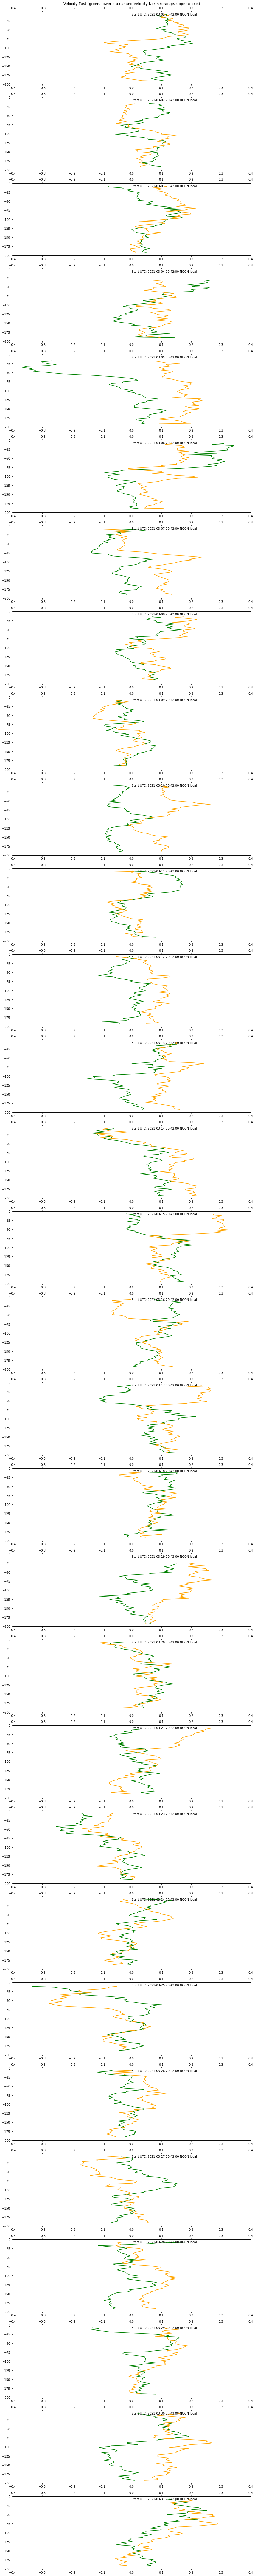

In [58]:
xrng = [(veast_lo, veast_hi), (vnorth_lo, vnorth_hi)]
pIdcs = GenerateTimeWindowIndices(df, dt64_from_doy(2021, 60), dt64_from_doy(2021, 91), noon0, noon1)
fig, axs = ChartAB(df, xrng, pIdcs, dsU.veast, dsU.z, 'Velocity East', 'green', \
                   dsV.vnorth, dsV.z, 'Velocity North', 'orange')

In [59]:
# plan: Superchart with multiple twin axes
